In [4]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [83]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from math import sqrt

from tracking.util import to_df, colorscale

In [6]:
from sympy.solvers import solve, solveset, nsolve, nonlinsolve
from sympy import Symbol, symbols, N
from sympy.matrices import Matrix

# Kalman Gain

In certain settings, Kalman Gain converges to a value which can be predicted. This property of the Kalman Filter will be useful when analyzing motion models and their errors for maneuvering and non-maneuvering targets. 

Let's start by considering a scheme in which we perform a sequence of measurements of an unchanging value with a known and constant measurement error $R$. In such setting, the state of the Kalman Filter $x_i$ will converge to the true value while the state covariance $P_i$ will converge to zero.

We start by taking the first measurement and using it to initialize Kalman Filter: $x_1 = z_1$ and $P_1 = R$. Then, we update Kalman Filter with each following measurement:

$$
\begin{align}
K = & \frac{P_{i}}{P_{i} + R}\\
x_{i+1} = & x_i + K(z_i - x_i)\\
P_{i+1} = & (K-1)^2P_i + K^2R
\end{align}$$

Let's simulate this process numerically.

In [16]:
X = 10 # true value

R = 1 # measurement error (variance)

# take the first measurement
z = np.random.normal(X, np.sqrt(R))

# initialize the Kalman Filter
x = z
P = R

# perform updates
trace = [(x, P)]
for _ in range(100):
    z = np.random.normal(X, np.sqrt(R))
    
    K = P/(P+R)
    x = x + K*(z-x)
    P = (1-K)**2 * P + K**2 * R

    trace.append((x, P))

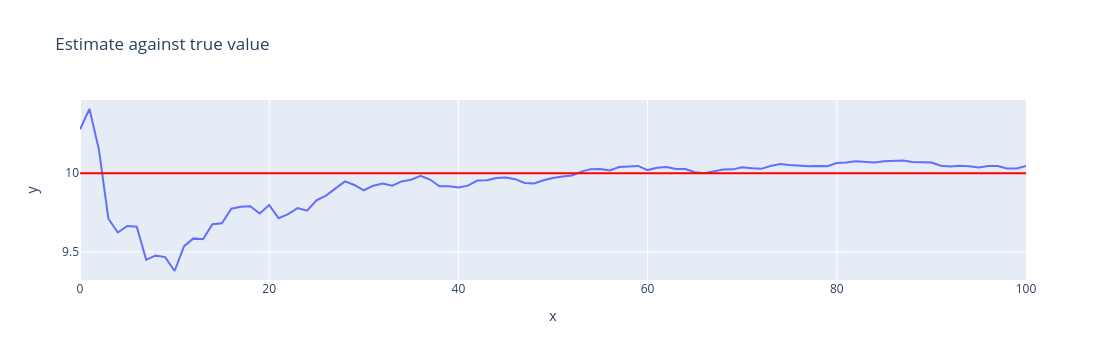

In [26]:
fig = ex.line(x=range(101), y=np.array(trace)[:,0], title='Estimate against true value')
fig.add_hline(y=X, line_color='red')

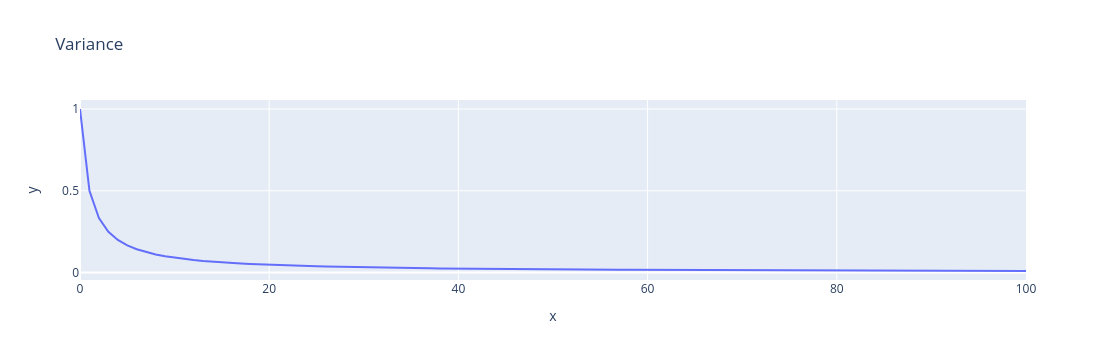

In [27]:
ex.line(x=range(101), y=np.array(trace)[:,1], title='Variance')

The above should be not at all surprising once we realize that the above is an equivalent to taking the average of $N$ realizations of a random normal variable with mean $X$ and variance $R$:

$$x_N = \frac{1}{N}\sum_i^N Y_i$$
$$Y \sim \mathcal{N}(X,R)$$

Central Limite Theorem tells us that when $N \rightarrow \infty$, $x_N$ converges to $X$ and variance expressed as $\frac{R}{N}$ converges to zero. Let's compare those two approaches.

In [67]:
def kalman(X, R, n):
    x = np.random.normal(X, np.sqrt(R))
    P = R
    trace = [x]
    for _ in range(n):
        z = np.random.normal(X, np.sqrt(R))
        K = P/(P+R)
        x = x + K*(z-x)
        P = (1-K)**2 * P + K**2 * R
        trace.append(x)
    return np.array(trace)

def average(X, R, n):
    return np.cumsum(np.random.normal(X, np.sqrt(R), size=n+1)) / np.arange(1, n+2)

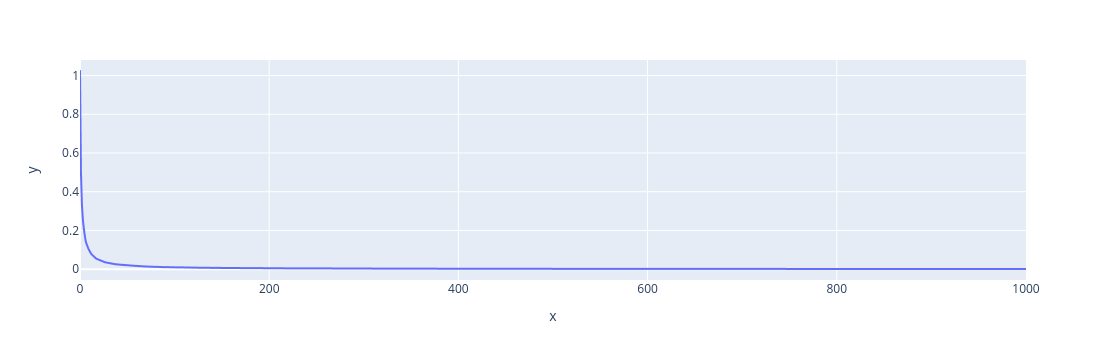

In [70]:
data_kalman = np.array([kalman(10, 1, 1000) for _ in range(1000)])
ex.line(x=range(1001), y=data_kalman.var(axis=0))

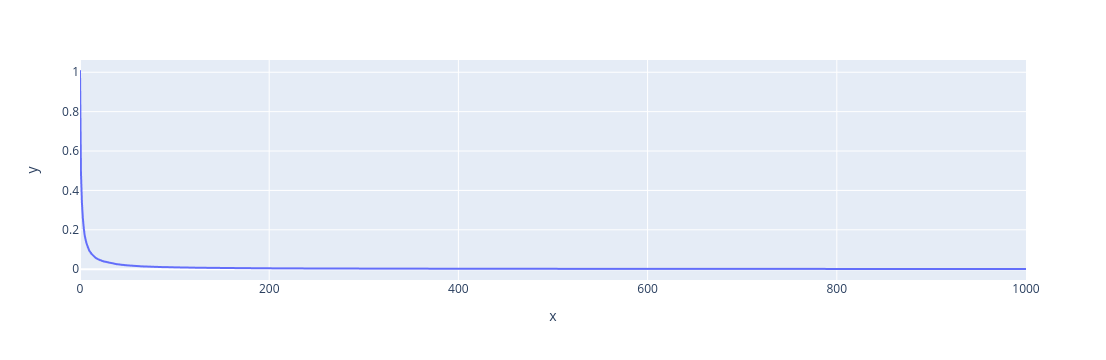

In [69]:
data_average = np.array([average(10, 1, 1000) for _ in range(1000)])
ex.line(x=range(1001), y=data_average.var(axis=0))

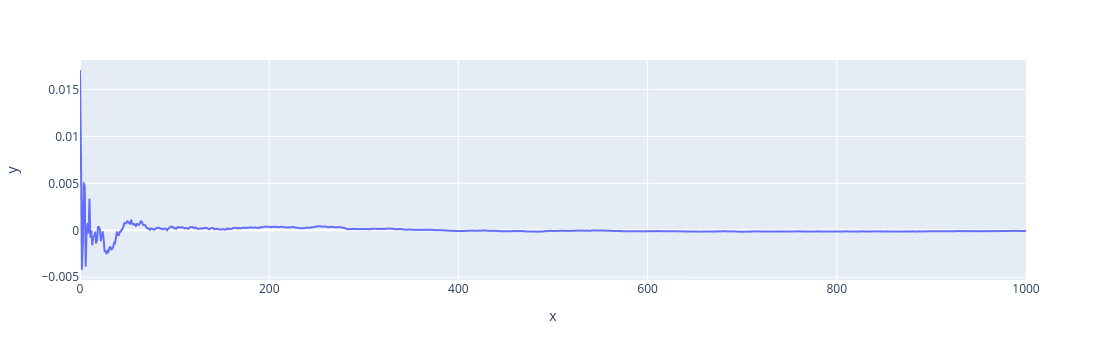

In [73]:
ex.line(y=data_kalman.var(axis=0) - data_average.var(axis=0))

## Kalman gain and variance

We can show that, in the above setting, estimated variance will always converge to zero. Let's start with the following two steps of the Kalman update:

$$K = \frac{P_{i}}{P_{i} + R}$$
$$P_{i+1} = (K-1)^2P_i + K^2R$$

Now we can ask: for what value $P$ we obtain the equality $P = P_{i+1} = P_i$? We can easily answer that question:

$$P = (K-1)^2P + K^2R$$
$$P = (\frac{P}{P+R} - 1)^2P + (\frac{P}{P+R})^2R$$
$$P = \frac{PR^2}{(P+R)^2} + \frac{PR^2}{(P+R)^2}$$
$$P = \frac{2PR^2}{(P+R)^2}$$

Since $R$ cannot be equal zero, the only solution to the above is $P=0$.

## With process noise

In the presence of process noise, $P$ converges to a non-zero value which is a function of both $Q$ and $R$.

$$P_{t+1,t} = P_{t} + Q$$
$$K = \frac{P_{t+1,t}}{P_{t+1,t} + R}$$
$$P_{t+1,t+1} = (1-K)^2P_{t+1,t} + K^2R = (1-K)P_{t+1,t}$$

Once we again we ask, for which value $P$ we obtain $P = P_{t+1,t+1} = P_{t+1}$? In order to answer this question, we need to solve $P = (1-K)P$ where $K = \frac{P+Q}{P+Q+R}$:

$$P = (1 - \frac{P+Q}{P+Q+R})(P+Q)$$
$$P = P + Q - \frac{(P+Q)^2}{P+Q+R}$$
$$\frac{(P+Q)^2}{P+Q+R} - Q = 0$$
$$P^2 + 2PQ + Q^2 - PQ - Q^2 - QR$$
$$P^2 + PQ - QR = 0$$

$$P = \frac{-Q \pm \sqrt{Q^2 + 4QR}}{2}$$

Since $P$ cannot be negative, this leaves only one solution: $P = \frac{1}{2}(-Q + \sqrt{Q^2 + 4QR})$. Let's verify that numerically.

In [81]:
def kalman_with_noise(Q, R, n):
    P = R
    for _ in range(n):
        P = P + Q
        K = P/(P+R)
        P = (1-K)**2 * P + K**2 * R
    return P

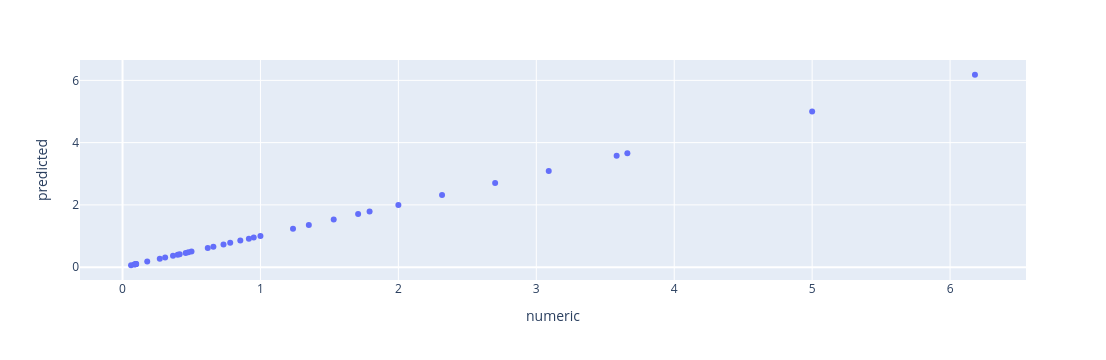

In [103]:
trace = []
for Q in [.1, .5, 1, 2, 5, 10]:
    for R in [.1, .5, 1, 2, 5, 10]:
        trace.append((Q, R, kalman_with_noise(Q, R, 100), .5*(sqrt(Q**2 + 4*Q*R)-Q)))

data = to_df(np.array(trace), columns=['Q', 'R', 'numeric', 'predicted'])
ex.scatter(data, x='numeric', y='predicted')

In [105]:
data[['predicted', 'numeric']].corr()

,predicted,numeric
predicted,1.0,1.0
numeric,1.0,1.0


As we can see above, we achieve perfect agreement between predicted $P$ and the value to which converges `kalman_with_noise()`.

## Kalman filter with unobservable state

Finally, let's consider a situation where one variable in of the Kalman Filter state is unobservable. In order to define the state transition matrix $F$, we will assume a constant sampling period $t$. How will the covariance converge?

In [135]:
Px, Pv, Pxv, Qx, Qv, Rx, t = symbols("P_x, P_v, P_xv, Q_x, Q_v, R_x, t", positive=True)

State transition matrix:

In [136]:
F = Matrix([[1, t], [0, 1]])
F

Matrix([
[1, t],
[0, 1]])

Measurement matrix:

In [113]:
H = Matrix([[1, 0]])
H

Matrix([[1, 0]])

Process noise matrix:

In [ ]:
Q = Matrix([[Qx, 0], [0, Qv]])

Measurement error:

In [ ]:
R = Matrix([Rx])

Now we can define the sequence of equations which will allows us to find the value to which state variance converges:

In [137]:
P = Matrix([[Px, Pxv], [Pxv, Pv]])
Pn = F*P*F.T + Q
S = H*Pn*H.T + Rm
K = Pn*H.T*S.inv()

X = P - Pn + K*S*K.T

In [138]:
X

Matrix([
[-P_xv*t - Q_x - t*(P_v*t + P_xv) + (P_x + P_xv*t + Q_x + t*(P_v*t + P_xv))**2*(P_x + P_xv*t + Q_x + R + t*(P_v*t + P_xv))/(P_v*t**2 + P_x + 2*P_xv*t + Q_x + R)**2, -P_v*t + (P_v*t + P_xv)*(P_x + P_xv*t + Q_x + t*(P_v*t + P_xv))*(P_x + P_xv*t + Q_x + R + t*(P_v*t + P_xv))/(P_v*t**2 + P_x + 2*P_xv*t + Q_x + R)**2],
[              -P_v*t + (P_v*t + P_xv)*(P_x + P_xv*t + Q_x + t*(P_v*t + P_xv))*(P_x + P_xv*t + Q_x + R + t*(P_v*t + P_xv))/(P_v*t**2 + P_x + 2*P_xv*t + Q_x + R)**2,                                        -Q_v + (P_v*t + P_xv)**2*(P_x + P_xv*t + Q_x + R + t*(P_v*t + P_xv))/(P_v*t**2 + P_x + 2*P_xv*t + Q_x + R)**2]])

By comparing the above matrix to a zero matrix, we form a system of equations. In order to solve the above for variance, we supply actual values for measurement and process noise and a specific sampling interval.

In [189]:
def solve_kalman_2d(Qx, Qv, R, t):
    # define constants
    F = Matrix([[1, t], [0, 1]])
    H = Matrix([[1, 0]])
    Q = Matrix([[Qx, 0], [0, Qv]])
    Rm = Matrix([R])

    # define equations
    P = Matrix([[Px, Pxv], [Pxv, Pv]])
    Pn = F*P*F.T + Q
    S = H*Pn*H.T + Rm
    K = Pn*H.T*S.inv()

    # solve for variance
    X = P - Pn + K*S*K.T
    res = nonlinsolve([X[0,0], X[0, 1], X[1, 1]], [Px, Pv, Pxv])

    # find real-numbered solution consisting of positive numbers and return it as floats
    for solution in res:
        if any([s.is_imaginary for s in solution]):
            continue
        a, b, c = [s.evalf() for s in solution]
        if a < 0 or b < 0 or c < 0:
            continue
        subs = {Px: a, Pv: b, Pxv: c}
        return (np.asarray(P.evalf(subs=subs), dtype=float), np.asarray(K.evalf(subs=subs), dtype=float))
    
    raise Exception("No real-numbered positive solution found")

Now, we can obtain the numeric values for both the steady-state covariance matrix and the steady-state Kalman gain.

In [192]:
res = solve_kalman_2d(1, 2, 13, 1)
res

(array([[7.9193446 , 3.1876811 ],
        [3.1876811 , 4.96871823]]),
 array([[0.60918035],
        [0.24520624]]))

Let's now compare results calculated in either of these ways:

In [178]:
def simulate_kalman_2d(Qx, Qv, R, t):
    H = np.array([[1, 0]])
    R = np.eye(1) * R
    Q = np.array([[Qx, 0], [0, Qv]])
    F = np.array([[1, t], [0, 1]])

    P = Q
    for _ in range(100):
        P = F @ P @ F.T + Q
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
    
        P = P - K @ S @ K.T
    
    return P, K

In [193]:
trace = []
for Q in [.1, .5, 1, 2, 5, 10]:
    for R in [.1, .5, 1, 2, 5, 10]:
        trace.append((Q, R, simulate_kalman_2d(Q, Q, R, 1), solve_kalman_2d(Q, Q, R, 1)))

What is the maximum different between covariance matrices?

In [198]:
np.max([np.max(P_sim - P_solved) for _, _, (P_sim, _), (P_solved, _) in trace])

6.716849298982197e-15

We observe practical equivalence. How about Kalman gain?

In [199]:
np.max([np.max(K_sim - K_solved) for _, _, (_, K_sim), (_, K_solved) in trace])

2.220446049250313e-16

Again, equivalent for all practical intents and purposes.

# Kalman Gain

Let's start by considering the task of tracking a single target, with a single sensor of known and constant measurement error $R$, at a constant sampling interval $T$. Measurements and filter state are single-dimensional.

Kalman Filter will be initialized with measurement $x_1 = z_1$ and variance $P_1 = R$. Then, at each interval $T$, will be provided with a single measurement of the same variance $R$. In the absence of process noise, state estimate will converge to the real 